In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Choose GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU ID to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Config=tf.compat.v1.ConfigProto(allow_soft_placement=True)
Config.gpu_options.allow_growth=True

In [3]:
Img_CVD_path     = 'C:\\Users\\Haoti\\.spyder-py3\\CS760_Final_Project\\COVID-new-1\\'
Img_non_CVD_path = 'C:\\Users\\Haoti\\.spyder-py3\\CS760_Final_Project\\non-COVID-new-1\\'

In [4]:
import os, os.path

list_COVID     = os.listdir(Img_CVD_path)
list_non_COVID = os.listdir(Img_non_CVD_path)
N_COVID        = len(list_COVID)
N_non_COVID    = len(list_non_COVID)
print('Number of Covid files is', N_COVID)
print('Number of non Covid files is', N_non_COVID)

Number of Covid files is 1252
Number of non Covid files is 1228


In [5]:
# Load Image Data from folder
from matplotlib import image

L_COVID     = np.zeros((N_COVID, 3))
L_non_COVID = np.zeros((N_non_COVID, 3))
Image_CVD     = np.zeros((N_COVID, 200, 200, 3))
Image_non_CVD = np.zeros((N_non_COVID, 200, 200, 3))

for i in range(N_COVID):
    image_COVID  = image.imread(Img_CVD_path + 'Covid (' + str(i+1) + ').png')
    L_COVID[i,:] = image_COVID.shape
    Image_CVD[i,:,:,:]  = image_COVID
    
for j in range(N_non_COVID):
    image_non_COVID  = image.imread(Img_non_CVD_path + 'Non-Covid (' + str(j+1) + ').png')
    L_non_COVID[j,:] = image_non_COVID.shape
    Image_non_CVD[j,:,:,:]  = image_non_COVID

In [13]:
Image_total = np.concatenate((Image_CVD, Image_non_CVD), axis=0)
Image_total.shape


(2480, 200, 200, 3)

In [16]:
# Generate the label, COVID==1, non_COVID==0
label = np.zeros((Image_total.shape[0],1))
label[:N_COVID] = 1

In [18]:
# Set up Neural Network
X_train, X_test, Y_train, Y_test = train_test_split(Image_total, label,  test_size=0.4, random_state=109)
X_test,  X_cv,   Y_test,  Y_cv   = train_test_split(X_test,      Y_test, test_size=0.5, random_state=109)



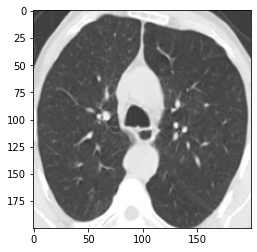

In [25]:
X_train.shape[0]
X_train[0,:,:]
plt.imshow(X_train[0,:,:])

In [20]:
import tensorflow.keras.backend as K

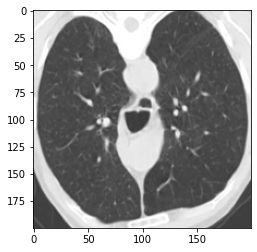

In [26]:
rev = K.reverse(X_train[0,:,:],axes=0)
plt.imshow(rev)

In [20]:
# Define Neural Network Layers

def conv_2d(x,filt):
    y = tf.keras.layers.Conv2D(filters=filt, kernel_size=(3,3),
                               padding='same', activation='linear')(x)
    return y

def fully_connect(x,filt,activate):
    y = tf.keras.layers.Dense(filt, activation=activate, 
                              kernel_initializer='he_uniform')(x)
    return y

def max_pool(x):
    y = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1), padding='same', data_format=None)(x)
    return y

In [33]:
input_layer = tf.keras.Input(shape=(200, 200, 3))

conv_1 = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), input_shape=(200, 200, 3), padding='valid', activation='relu')(input_layer)
conv_2 = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu')(conv_1)
max_p1 = max_pool(conv_2)
conv_3 = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')(max_p1)
conv_4 = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')(conv_3)
max_p2 = max_pool(conv_4)
conv_5 = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu')(max_p2)
conv_6 = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu')(conv_5)
max_p3 = max_pool(conv_6)

flatten = tf.keras.layers.Flatten()(max_p3)
dense1  = fully_connect(flatten, 1024, 'relu')
dense2  = fully_connect(dense1, 256, 'relu')
output_layer  = fully_connect(dense2, 1, 'sigmoid')

# model = tf.keras.models.Model([input_layer_1, input_layer_2], output_layer)
model = tf.keras.models.Model(input_layer, output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 99, 99, 32)        896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 64)        0   

In [35]:
sgd = tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.6, nesterov=True)
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])

In [36]:
epoch = 40
history = model.fit(X_train, Y_train, batch_size=37, epochs=epoch, 
                    steps_per_epoch=40, validation_data=(X_cv, Y_cv))

predict = model.predict(X_test)

score = model.evaluate(X_test, Y_test, verbose=1)

Train on 1488 samples, validate on 496 samples
Epoch 1/40
1451/1488 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.6733 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00Epoch 40/40
496/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [37]:
Y_pred = np.round(predict)
res = sum(x == y for x, y in zip(Y_pred, Y_test)) /  len(Y_pred)

In [38]:
res

array([0.71572581])